# Cubic Spline Interpolation for Yield Curve Modelling

### Jacob Ender

In this notebook, we use the method of cubic spline interpolation to model the US Treasury Yield Curve. A general method is given to construct the curve given a set of data and a desired date. We then check our model against the true yield curve to analyze the accuracy of the model. This was a project I used to get familiar with some basic interpolation methods, to understand the yield curve, and was a good exercise in collecting appropriate data.

This interpolation method follows the methods of Roi Polanitzer (https://medium.com/@polanitzer/cubic-spline-in-python-estimate-the-dollar-risk-free-yield-curve-in-isreal-as-of-december-31-2022-b365b9d19c31).  

A good deal of help came from [Alex Kazachek](https://akazachek.com/), who helped with the structure of the program, as well as writing the code to generate an appropriate number of points in each interval of durations (and showing me how to use seaborn). Alex also gave me the framework for plotting the true yields against the estimated yields.

## Constructing the Yield Curve

In [1]:
from scipy.interpolate import CubicSpline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import seaborn as sns

# This just suppressed a future TypeError warning.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Pull in file list and array of durations

In [2]:
dir = "./data/"
files = os.listdir(dir)
durations = [0.25, 0.33, 0.5, 1, 2, 3, 5, 7, 10, 30]

Read in CSV data - by default, the yields are strings, so we use the p2f() function to convert it to a float.

In [3]:
def p2f(x):
    return float(x.strip('%'))/100

def get_df(row):
    
    rows = [0,row]
    yields = []
    for f in files:
        dta = pd.read_csv(dir + f, usecols= ['Date', 'Close'], skiprows = lambda x : x not in rows, converters={'Close':p2f})
        yields.append(dta["Close"])

    yields = np.array(yields).flatten()
    d = {'Duration': durations, 'Yield': yields}
    
    return pd.DataFrame(d)

### Cubic Spline Interpolation

We use SciPy's CubicSpline function to interpolate the yield data with a piecewise cubic function. This models our yield curve by interpolating between the discrete observations in our data.

In [4]:
def construct_curve(df):
    
    f = CubicSpline(df["Duration"], df["Yield"], bc_type="natural")
    n_dur = len(durations)
    n_inter_per_year = 2
    xvals = np.array([])

    # Since the difference between the duration of consecutive bonds is non-constant, we ensure that 
    # the number of points we construct between consecutive durations is similarly non-constant.
    for i in range(n_dur - 1):
        time_elapsed = (durations[i+1] - durations[i])
        points = np.ceil(time_elapsed * n_inter_per_year)
        ls = np.linspace(durations[i], durations[i+1], int(points), endpoint = False)
        xvals = np.concatenate((xvals, ls))
    xvals[-1] = durations[-1]

    # Apply cubic spline
    interpolate_y = f(xvals)
    interpolated_raw = {'Duration': xvals, 'Yield': interpolate_y}
    
    yield_curve = pd.DataFrame(interpolated_raw)
    yield_curve['RF'] = round(yield_curve['Yield']*100,5)
    return yield_curve

    


Seaborn is used to plot the curve. 

In [5]:
def plot(yield_curve, dur):
    
    M0 = np.min(yield_curve.RF) - 0.07
    M1 = np.max(yield_curve.RF) + 0.07

    fontsize=13

    fig, ax = plt.subplots(figsize=(13,7))

    dur = [0.25, 0.5, 1., 2., 3., 5., 7., 10., 30.]
    yield_curve["Observed"] = yield_curve["Duration"].isin(dur)
    yield_curve["Observed"] = yield_curve["Observed"].apply(lambda x: "Observed" if x else "Interpolated")

    sns.scatterplot(data = yield_curve, x = "Duration", y = "RF", hue = "Observed", ax = ax)
    sns.lineplot(data = yield_curve, x = "Duration", y = "RF", ax = ax)

    plt.xlabel('Duration',fontsize=fontsize)
    plt.ylabel('Yield',fontsize=fontsize)

    plt.xlim(0, 25)
    plt.ylim(M0, M1)
    plt.legend(loc="center right")
    plt.title("US Treasury Yield Curve - Cubic Spline Interpolation",fontsize=fontsize)

    plt.show()

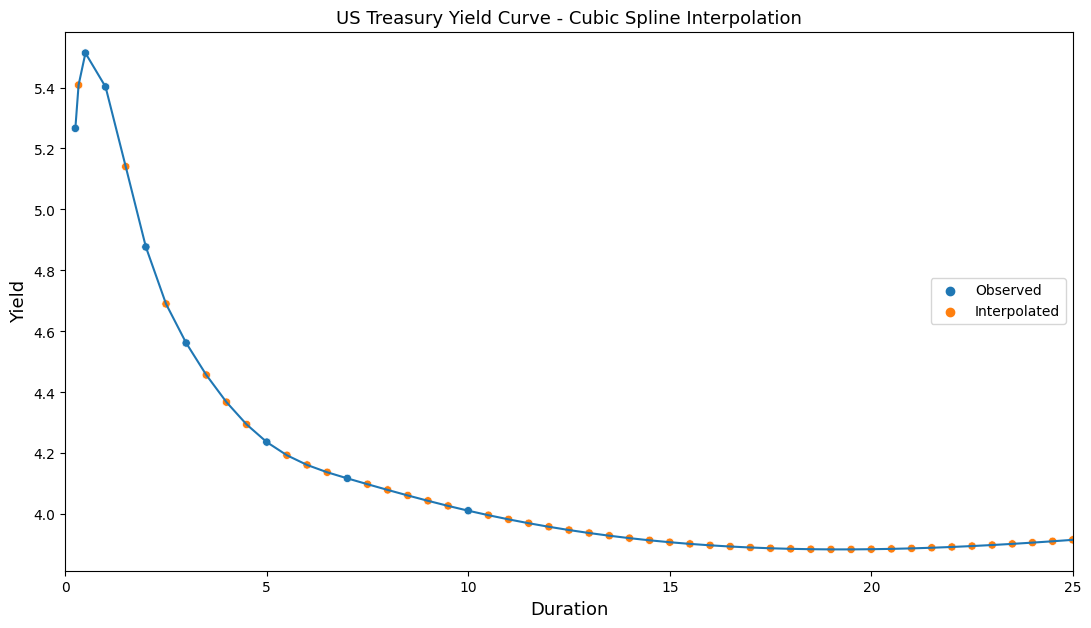

In [6]:
data = get_df(4) # 4 is the 4th row in the data frame, which corresponds to the date July 11, 2023.
curve = construct_curve(data)

plot(curve, curve["Duration"])

## Comparing our Estimates Against True Yields

Now, we wish to see how well our model did. The last cell allows for input of a maturity in years, and then plots the estimated yields against the true yields.

The cell below pulls in the true yields for a given bond duration, calculates their estimated yields using our methods above, and returns a tuple of the two, which we will plot later.

In [7]:
def true_estimated_yields(row):
    
    end_date = 20
    dates = range(1, end_date+1)
    true_yield = np.zeros(end_date)
    estimated_yield = np.zeros(end_date)
    drop_idx = row-1
    drop_dur = durations[drop_idx]

    for d in dates:
        df = get_df(d)
        true_yield[d - 1] = df["Yield"].iloc[drop_idx]
        df = df.drop(drop_idx)
        curve = construct_curve(df)
        estimated_yield[d - 1] = curve[curve["Duration"] == drop_dur]["Yield"]

    return (true_yield, estimated_yield, end_date)

Given a maturity, this cell will read the appropriate csv file and create a dataframe of the true and estimated yields on each date.

In [8]:
def dates(maturity):
    
    if (maturity in durations):
        findex = 0
        fdur = 0
        fcode = ''
        for i in range(0, len(durations)):
            if (durations[i] == maturity):
                findex = i+1
        if (maturity < 1):
            if (maturity == 0.25):
                fdur = fcode = '1M'
            elif (maturity == 0.33):
                fdur = fcode = '3M'
            elif (maturity == 0.5):
                fdur = fcode = '6M'
            fname = str(findex) + "_" + str(fdur) + ".csv"
        else:
            fname = str(findex) + "_" + str(maturity) + "Y" + ".csv"
            fcode = str(maturity) + "Y"
            
        true_yield = true_estimated_yields(findex)[0]
        estimated_yield = true_estimated_yields(findex)[1]
        end_date = true_estimated_yields(findex)[2]
        
        dates = pd.read_csv(dir + fname, usecols=['Date'])["Date"]
        df = pd.DataFrame({"true": true_yield, "estimate": estimated_yield}, index = dates[:end_date]) * 100
        df.index = pd.to_datetime(df.index)
        
        
        return (df, fcode)
    

Plotting the true and estimated yields against each other.

In [9]:
def draw_plot(maturity):
    
    df = dates(maturity)[0]
    dur = dates(maturity)[1]
    
    with plt.style.context("seaborn-v0_8-pastel", after_reset = True):
        f, ax = plt.subplots(figsize=(15, 5))
        sns.lineplot(data = df, x = df.index, y = "true", label = "True Yield", ax = ax)
        sns.lineplot(data = df, x = df.index, y = "estimate", label = "Estimated Yield", ax = ax)
        plt.xlabel("Date")
        plt.ylabel("Yield (%)")
        plt.title(dur + " US Treasury Yield")
        plt.show()

Try it out! Input one of the given maturities, and observe the difference in the true yields and the model's estimates.

Enter a maturity (in years): 3


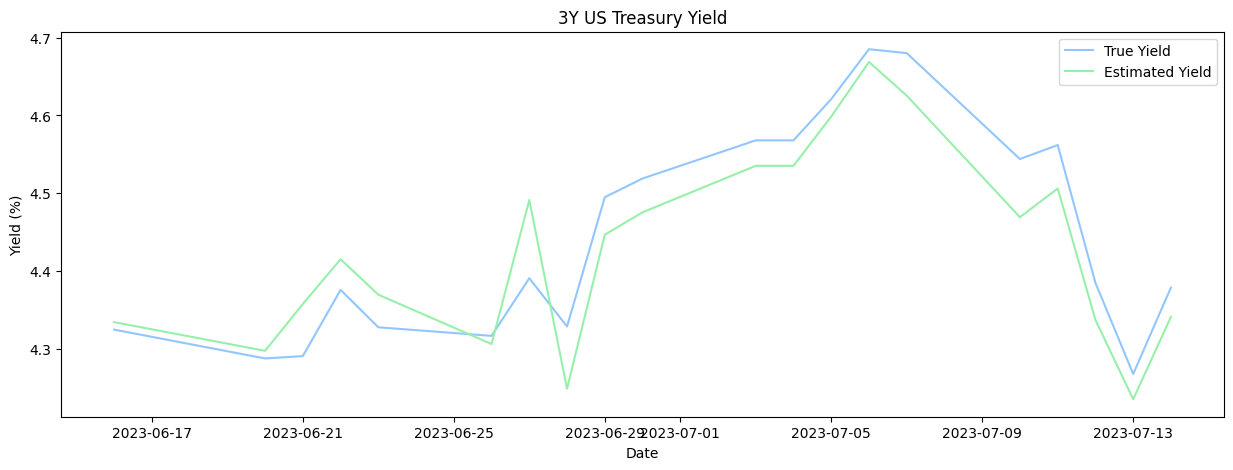

In [10]:
maturity_to_grab = input("Enter a maturity (in years): ")

m = float(maturity_to_grab)

if (m < 1):
    draw_plot(m)
else:
    draw_plot(int(m))
    